In [1]:
import sys
sys.argv.append("-lc=C:/Workspaces/AIC/simod/local_config_files/AIC/vga-manhattan-start_1830-real_speeds.cfg")
from amodsim.init import config

INFO:root:Loading config for project RoadmaptoolsConfig (can be overwritten later)
INFO:root:map_dir: FILL YOUR MAP DIR HERE
osm_source_url: https://s3.amazonaws.com/metro-extracts.mapzen.com/valencia_spain.osm.bz2
osm_map_filename: FILL YOUR MAP DIR HEREmap.osm
filtered_osm_filename: FILL YOUR MAP DIR HEREmap-filtered.osm
geojson_file: FILL YOUR MAP DIR HEREmap.geojson
cleaned_geojson_file: FILL YOUR MAP DIR HEREmap-cleaned.geojson
sanitized_geojson_file: FILL YOUR MAP DIR HEREmap-sanitized.geojson
simplified_file: FILL YOUR MAP DIR HEREmap-simplified.geojson
simplified_file_with_speed: FILL YOUR MAP DIR HEREmap-simplified-speed.geojson
simplified_file_with_speed_and_curvature: FILL YOUR MAP DIR HEREmap-simplified-speed-curvature.geojson
ap_nodes_file: FILL YOUR MAP DIR HEREnodes.geojson
ap_edges_file: FILL YOUR MAP DIR HEREedges.geojson
utm_center_lon: 50.0877506
utm_center_lat: 14.4209293
shift_utm_coordinate_origin_to_utm_center: False
shapely_error_tolerance: 0.005
osm_filter_para

In [14]:
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import numpy as np
import copy
import roadmaptools.inout
import roadmaptools.plotting
import amodsim.demand

In [3]:
HEATMAP_RESOLUTION = 200

# Prague
# MIN_LAT = 5_530_000
# MAX_LAT = 5_560_000
# MIN_LON = 445_000
# MAX_LON = 480_000

# Manhtattan
MIN_LAT = 4_505_000
MAX_LAT = 4_527_000
MIN_LON = 582_000
MAX_LON = 593_000

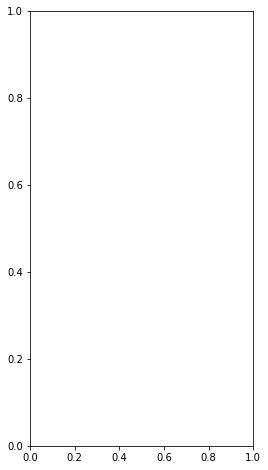

In [15]:
fig, map_axis = plt.subplots(1, 1)
fig.set_size_inches(figaspect((MAX_LAT - MIN_LAT) / (MAX_LON - MIN_LON)))
fig.subplots_adjust(wspace=0.01)

In [16]:
# road network
fc = roadmaptools.inout.load_geojson(config.main_roads_graph_filepath)
xList, yList = roadmaptools.plotting.export_edges_for_matplotlib(roadmaptools.plotting.geojson_edges_iterator(fc))
map_axis.plot(xList, yList, linewidth=0.2, color='black', zorder=1)

[22:50:00]: Loading geojson file from: C:\AIC Experiment Data\VGA Manhattan\maps\main_roads_map.geojson


In [7]:
# DEMAND
#  1 - generate empty heatmap
lon_range = np.arange(MIN_LON, MAX_LON, HEATMAP_RESOLUTION)
lat_range = np.arange(MIN_LAT, MAX_LAT, HEATMAP_RESOLUTION)
map = np.zeros((len(lat_range), len(lon_range)))

In [8]:
# 2 - fill heatmap
demand_data = amodsim.demand.load(config.trips_path)
xlist, ylist = roadmaptools.plotting.export_nodes_for_matplotlib(demand_data[["from_lat", "from_lon"]].to_numpy())
for i, x in enumerate(xlist):
    y = ylist[i]
    x_index = round((x - MIN_LON) / HEATMAP_RESOLUTION)
    y_index = round((y - MIN_LAT) / HEATMAP_RESOLUTION)
    map[y_index][x_index] += config.trips_multiplier

Loading demand from: C:/AIC Experiment Data/VGA Manhattan/trips.txt


In [9]:
# 3 - mask empty cells
map = np.ma.masked_where(map == 0, map)
cmap = copy.copy(plt.cm.get_cmap("Reds"))
cmap.set_bad(color='white')

In [17]:
heatmap = map_axis.matshow(map, extent=(MIN_LON, MAX_LON, MIN_LAT, MAX_LAT), origin='lower', cmap=cmap,
                           norm=LogNorm(vmin=1, vmax=map.max()), alpha=0.8)

In [18]:
fig.colorbar(heatmap, orientation='horizontal', fraction=0.048, pad=0.01)

In [19]:
# scale bar
scalebar = AnchoredSizeBar(map_axis.transData,
                           5000, '5 km', 'lower right',
                           pad=0.3,
                           color='black',
                           frameon=True,
                           size_vertical=1,
                           borderpad=0.5,
                           fontproperties=fm.FontProperties(size=18))

In [20]:
map_axis.add_artist(scalebar)

In [21]:
# remove ticks
map_axis.set_xticklabels([])
map_axis.set_yticklabels([])
map_axis.tick_params(
    which='both',  # both major and minor ticks are affected
    bottom=False,  # ticks along the bottom edge are off
    top=False,  # ticks along the top edge are off
    labelbottom=False, right=False, left=False, labelleft=False, labelright=False, labeltop=False)

In [22]:
map_axis.set_xlim(MIN_LON, MAX_LON)
map_axis.set_ylim(MIN_LAT, MAX_LAT)

plt.tight_layout(h_pad=1)

<Figure size 432x288 with 0 Axes>

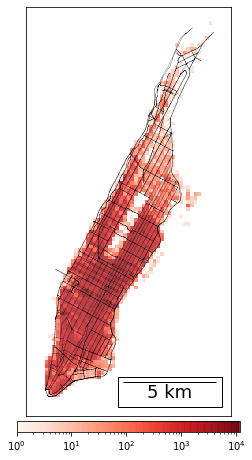

In [23]:
fig

In [24]:
fig.savefig(config.images.demand_heatmap, bbox_inches='tight', transparent=True, pad_inches=0.02, dpi=fig.dpi)

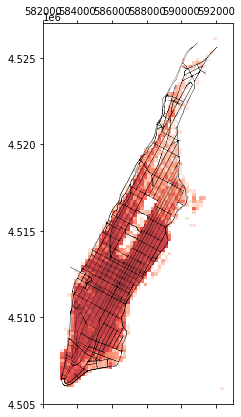

In [12]:
fig